# Very Basic Time Series Example, Extended and Adapted

This notebook is based on an example from the book "Probabilistic Programming and Bayesian Methods for Hackers"  
by Cam Davidson Pilon [[link](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC_current.ipynb)]. 

The example uses data consisting of the number of text messages sent over 74 days by a single person.

The original examples have been adapted, abbreviated, and extended with additional ideas to further explore Bayesian time series analysis.

The data is stored in a CSV file and will be read using pandas.

## The original example -- Text Message Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from plot_utils import MY_COLORS, plot_data_with_predictions

<Axes: >

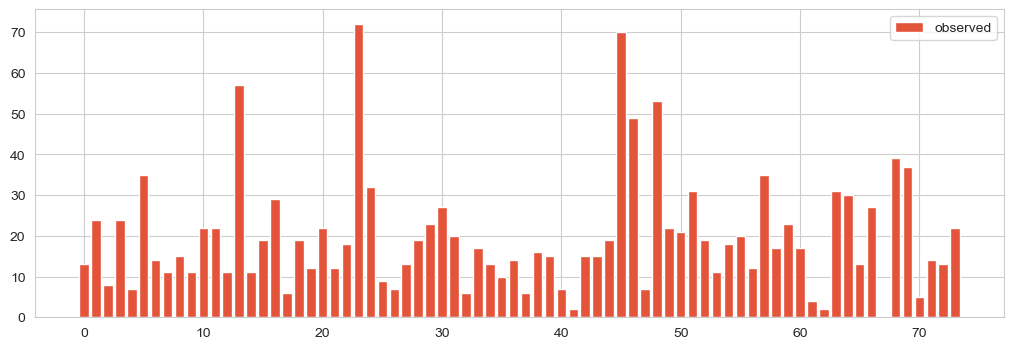

In [2]:
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plot_data_with_predictions(count_data)

Before modeling, let's analyze the chart. It suggests a change in behavior, possibly indicating an increase in the rate ($\lambda$) of text messages during the observation period.

**Modeling Approach**

We can use a Poisson distribution for daily counts, where:
$$
y_s \sim \text{Poisson}(\lambda)
$$
Assume $\lambda$ changes at some point $s$. We introduce two parameters, $\lambda_1$ (before $s$) and $\lambda_2$ (after $s$).

If no change occurred, the posterior distributions of $\lambda_1$ and $\lambda_2$ would be similar.

**Priors for $\lambda_1$ and $\lambda_2$**

We choose an exponential prior for each $\lambda$:
$$
\lambda \sim \text{Exponential}(\alpha)
$$
where $\alpha$ is a hyperparameter, chosen as the inverse of the average count data.

**Prior for $s$**

Since it's unclear when the change occurred, we use a uniform prior:
$$
s \sim \text{Uniform}(0, N)
$$
Next, we'll use PyMC to model the posterior distributions of these parameters.
```​⬤

In [3]:
with pm.Model() as model:
    alpha = 1.0 / count_data.mean()  # Recall count_data is the
    # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [4]:
with model:
    idx = np.arange(n_count_data)  # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [5]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [6]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10_000, tune=5_000, step=step, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 3 seconds.


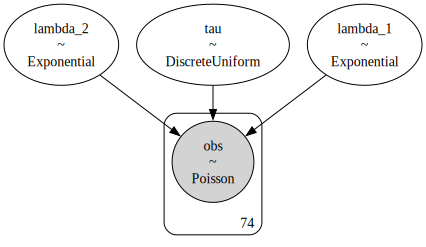

In [7]:
# use graphviz to visualize
pm.model_to_graphviz(
    model
)  # append `.view()` if you can't see the image in your notebook

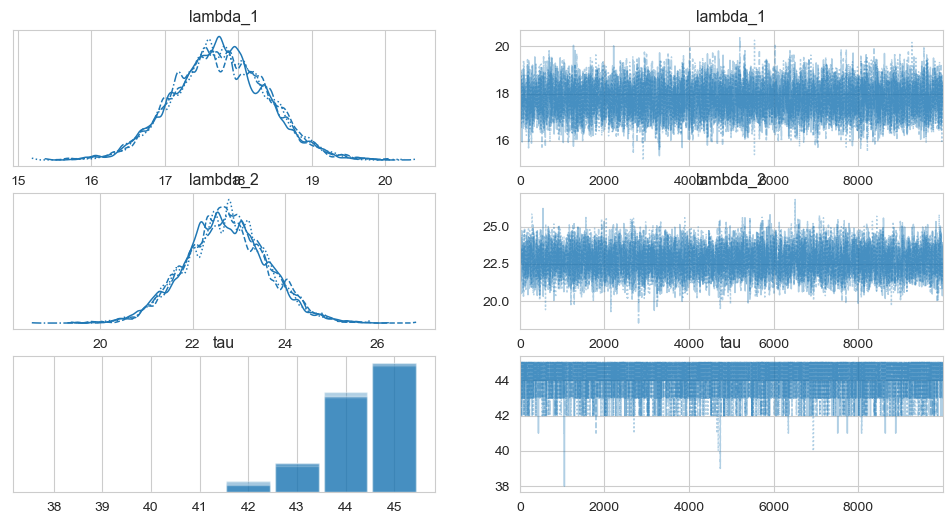

In [8]:
az.plot_trace(trace, compact=True);

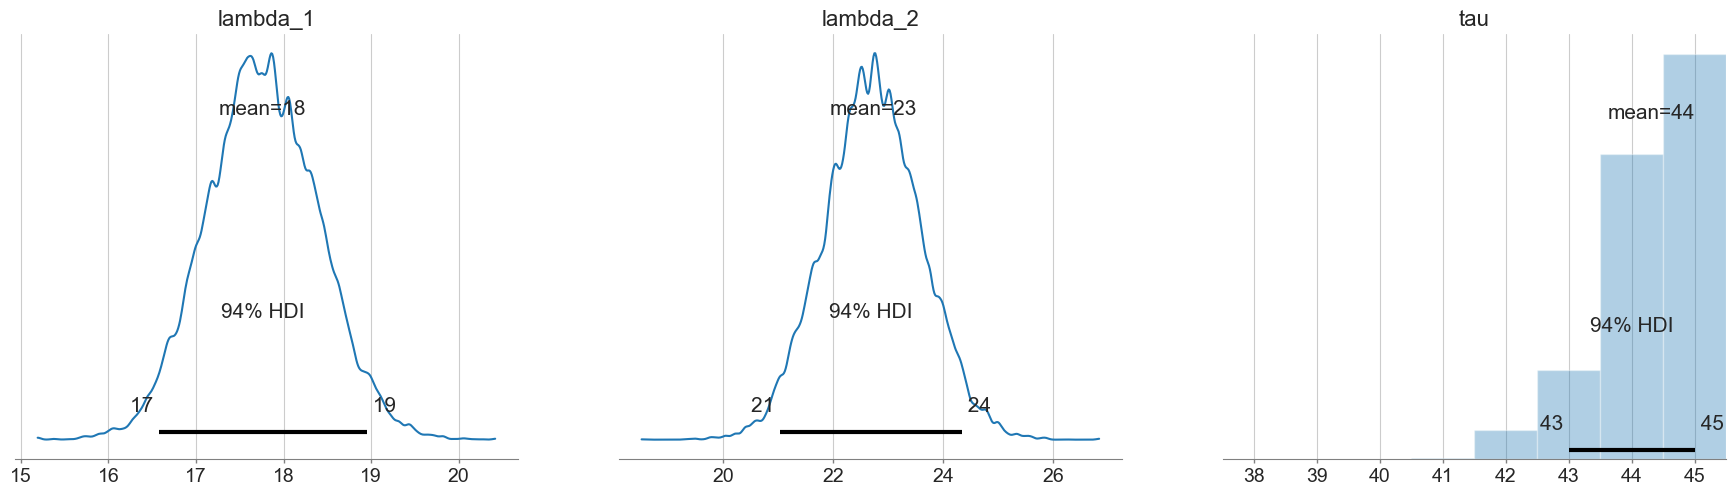

In [9]:
az.plot_posterior(trace, var_names=["lambda_1", "lambda_2", "tau"]);

## What now?

What can we do now, that we have the posterior distributions of $\lambda_1$, $\lambda_2$, and $s$? We can calculate the expected number of text messages for each day, given the data. This will help us understand the change in behavior.

In [10]:
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
tau_samples = trace.posterior["tau"].values.flatten()
lambda_1_samples = trace.posterior["lambda_1"].values.flatten()
lambda_2_samples = trace.posterior["lambda_2"].values.flatten()

In [11]:
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples  # True if before tau, False if after
    # had we only had a single lambda, the expected value of texts
    # would be lambda. But now we have two. So we must average them.
    expected_texts_per_day[day] = (
        lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()
    ) / len(tau_samples)

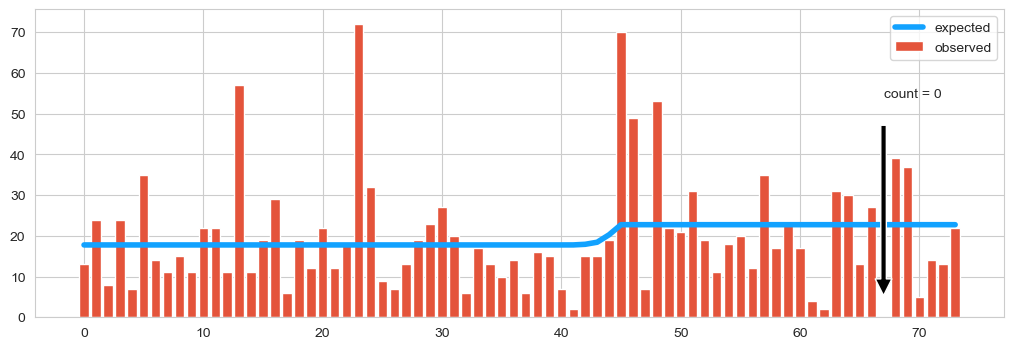

In [12]:
ax = plot_data_with_predictions(count_data, expected_texts_per_day)
# higlight the points where the count is zero. Use arrows
for i in np.where(count_data == 0)[0]:
    ax.annotate(
        "count = 0",
        xy=(i, 0),
        xytext=(i, max(count_data) * 0.75),
        arrowprops=dict(facecolor="black", shrink=0.1),
    )

We can see the change in behavior around day 45. The expected number of text messages received per day increased after this point.

## More useful inferences

### Outlier detection

We can see that on day 67, the number of text messages received was zero. How unlikely is this event? We can calculate the posterior probability of this event. 

In [13]:
def simulate_alternative_past(lambda_1, lambda_2, tau, n_days):
    simulated_texts = np.empty(n_days)
    for t in range(n_days):
        rate = lambda_1 if t < tau else lambda_2
        simulated_texts[t] = np.random.poisson(rate)
    return simulated_texts

In [14]:
n_simulations = 10_000  # Number of alternative pasts to simulate
simulated_histories = []
for _ in range(n_simulations):
    idx = np.random.randint(len(lambda_1_samples))
    simulated_texts = simulate_alternative_past(
        lambda_1_samples[idx], lambda_2_samples[idx], tau_samples[idx], len(count_data)
    )
    simulated_histories.append(simulated_texts)
simulated_histories = np.array(simulated_histories)
simulated_histories.shape

(10000, 74)

<Axes: >

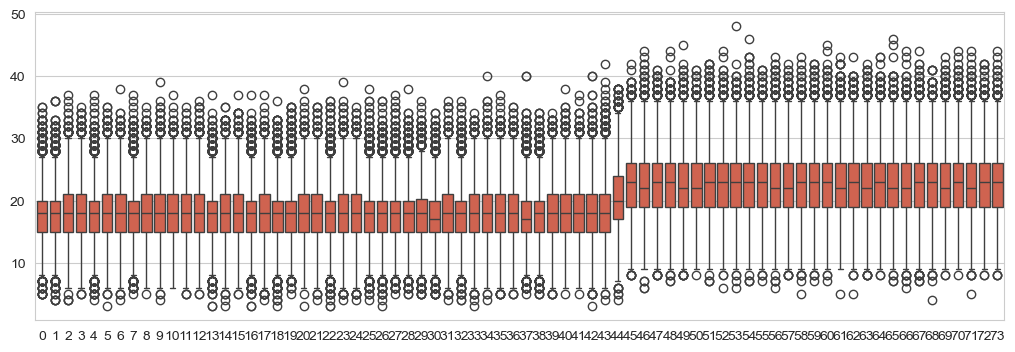

In [15]:
fig, ax = plt.subplots(figsize=(12.5, 4))
sns.boxplot(data=simulated_histories, color=MY_COLORS[0], ax=ax)

In [16]:
sel_history_contains_zero = (simulated_histories == 0).any(axis=1)
p_zero_texts = sel_history_contains_zero.mean()
print(f"Probability of receiving zero texts on at least one day: {p_zero_texts:.3%}")

Probability of receiving zero texts on at least one day: 0.000%


### Plannign for the future

What if, for some reason, we are not allowed to receive more than 45 messages in a single day. How likely are we expected to experience this situation?

In [17]:
sel_above_45 = (simulated_histories > 45).any(axis=1)
p_above_45 = sel_above_45.mean()
print(
    f"Probability of receiving more than 45 texts on at least one day: {p_above_45:.3%}"
)

Probability of receiving more than 45 texts on at least one day: 0.030%


The very low probability of receiving more than 45 texts on at least one day in the history is clearly an issue. We can clearly see that our actual data contains quite a few such days  

Text(0.5, 1.0, '5 days with more than 45 messages')

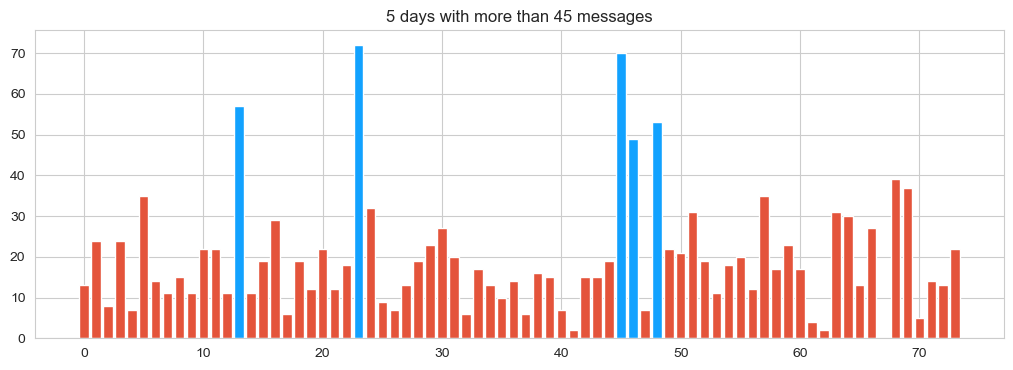

In [18]:
actual_n_above_45 = (count_data > 45).sum()
sel_actual_above_45 = count_data > 45
fig, ax = plt.subplots(figsize=(12.5, 4))
ax.bar(
    np.where(~sel_actual_above_45)[0],
    count_data[~sel_actual_above_45],
    color=MY_COLORS[0],
)
ax.bar(
    np.where(sel_actual_above_45)[0],
    count_data[sel_actual_above_45],
    color=MY_COLORS[1],
)
ax.set_title(f"{actual_n_above_45} days with more than 45 messages")

**What does that mean?**

> All models are wrong, some are useful
>
> --  George E. P. Box, a British statistician 

